In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ShuffleSplit

import pandas as pd
import seaborn as sns

<IPython.core.display.Javascript object>

In [8]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Section 1: Data generation

In [9]:
data_df = pd.DataFrame()
n = 100
offset = 2
x = np.linspace(-3, 3, 1000)
x_train = np.random.choice(x, n)
train_df = pd.DataFrame(
    {
        "x": x_train,
        "y": np.concatenate(
            (np.sin(x_train[:10]) - offset, -np.sin(x_train[10:]) + offset)
        )
        + np.random.randn(n),
        "series": n * ["train1"],
    }
)

data_df = pd.concat([data_df, train_df])

train_df = pd.DataFrame(
    {
        "x": x_train,
        "y": -np.sin(x_train) + np.random.randn(n) + offset,
        "series": n * ["train1b"],
    }
)

data_df = pd.concat([data_df, train_df])

x_train = np.random.choice(x, n)

train_df = pd.DataFrame(
    {
        "x": x_train,
        "y": np.concatenate(
            (np.sin(x_train[:10]) - offset, 3 * np.sin(x_train[10:]) + offset)
        )
        + np.random.randn(n),
        "series": n * ["train2"],
    }
)

data_df = pd.concat([data_df, train_df])

<IPython.core.display.Javascript object>

In [10]:
n_deploy = 20
x_deploy = np.random.choice(x, n_deploy)

train_df = pd.DataFrame(
    {
        "x": x_deploy,
        "y": np.sin(x_deploy) + np.random.randn(n_deploy) / 2 - offset,
        "series": n_deploy * ["deploy1"],
    }
)

data_df = pd.concat([data_df, train_df])

train_df = pd.DataFrame(
    {
        "x": x_deploy,
        "y": np.sin(x_deploy) + np.random.randn(n_deploy) / 2 - offset,
        "series": n_deploy * ["deploy2"],
    }
)

data_df = pd.concat([data_df, train_df])

<IPython.core.display.Javascript object>

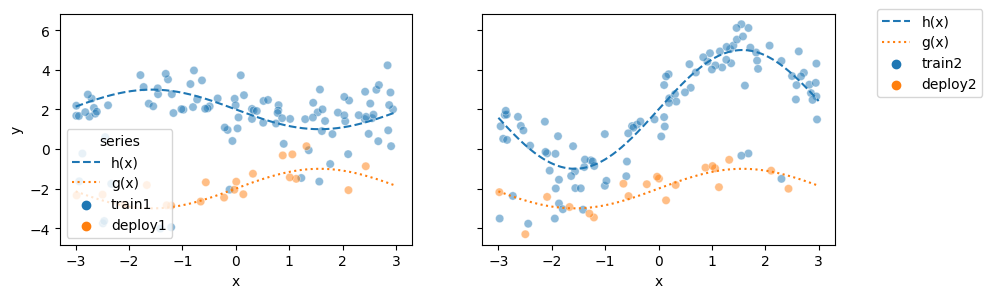

<IPython.core.display.Javascript object>

In [11]:
# visualize generated data 
plot_df = data_df[data_df["series"].isin(["train1", "deploy1"])]

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey="row")
ax = axes.flatten()[0]
ax.plot(x, -np.sin(x) + offset, linestyle="--", label="h(x)")
ax.plot(x, np.sin(x) - offset, linestyle=":", label="g(x)")
sns.scatterplot(data=plot_df, x="x", y="y", hue="series", ax=ax, alpha=0.5)

plot_df = data_df[data_df["series"].isin(["train2", "deploy2"])]
ax = axes.flatten()[1]
ax.plot(x, 3 * np.sin(x) + offset, linestyle="--", label="h(x)")
ax.plot(x, np.sin(x) - offset, linestyle=":", label="g(x)")
sns.scatterplot(data=plot_df, x="x", y="y", hue="series", ax=ax, alpha=0.5)
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [12]:
def nn_pipeline(
    Xtrain, # train data
    Ytrain, # train labels 
    Xdeploy, # deployment data
    Ydeploy, # deployment labels
    num_iter=10, # number iteration (only applies for random sampling)
    approx_range=None, # array of values to appoximation function
    hidden_layer_size=(8, 3), #
    loss_curve=False, # save loss curve 
    group_loss=False, # group loss by (x < 0 and x >= 0)
    random_sample=True, #randomly sample from generated data
):
    loss_list = []
    output_approx = []
    train_points = []
    loss_curve_list = []
    for n in np.linspace(10, 100, 10):
        for i in range(num_iter):
            clf = MLPRegressor(
                solver="adam",
                alpha=1e-5,
                hidden_layer_sizes=hidden_layer_size,
                max_iter=10000,
                random_state=1,
            )
            if random_sample:
                train_index = np.random.randint(0, 100, int(n))
            else:
                train_index = range(int(n))
            clf.fit(Xtrain[train_index].reshape(-1, 1), Ytrain[train_index])
            dep_mse = np.square(clf.predict(Xdeploy.reshape(-1, 1)) - Ydeploy).mean()
            train_mse = np.square(clf.predict(Xtrain.reshape(-1, 1)) - Ytrain).mean()

            pos_index = np.where(Xdeploy >= 0)[0]
            dep_mse_pos = np.square(
                clf.predict(Xdeploy[pos_index].reshape(-1, 1)) - Ydeploy[pos_index]
            ).mean()
            neg_index = np.where(Xdeploy < 0)[0]
            dep_mse_neg = np.square(
                clf.predict(Xdeploy[neg_index].reshape(-1, 1)) - Ydeploy[neg_index]
            ).mean()

            if group_loss:
                loss_list.append(
                    {
                        "run": i,
                        "n": n,
                        "dep_mse": dep_mse,
                        "train_mse": train_mse,
                        "pos_mse": dep_mse_pos,
                        "neg_mse": dep_mse_neg,
                    }
                )
            else:
                loss_list.append(
                    {"run": i, "n": n, "dep_mse": dep_mse, "train_mse": train_mse}
                )

        if type(approx_range) is np.ndarray:
            output_approx.append(clf.predict(approx_range.reshape(-1, 1)))
            train_points.append(train_index)
        if loss_curve:
            loss_curve_list.append(clf.loss_curve_)

    df = pd.DataFrame(loss_list)
    if type(approx_range) is np.ndarray:
        if loss_curve:
            return df, clf, np.asarray(output_approx), train_points, loss_curve_list
        else:
            return df, clf, np.asarray(output_approx), train_points
    else:
        if loss_curve:
            return df, clf, loss_curve_list
        else:
            return df, clf

<IPython.core.display.Javascript object>

(0.0, 25.0)

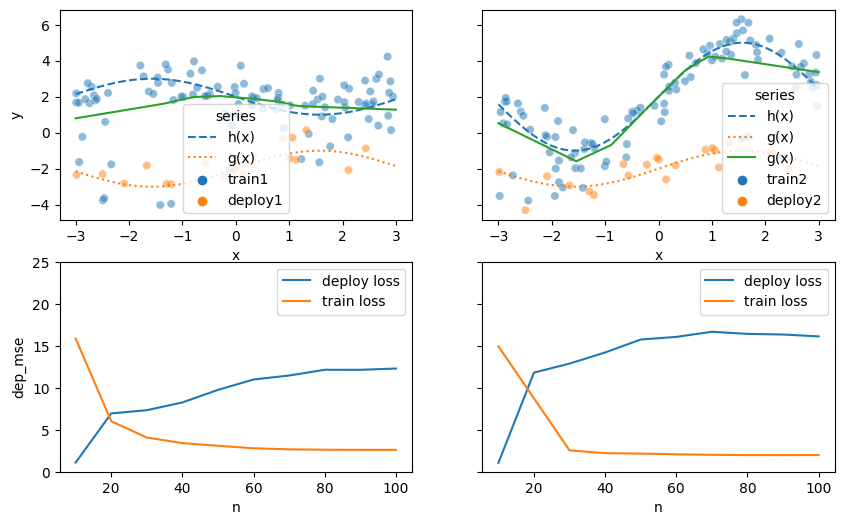

<IPython.core.display.Javascript object>

In [13]:
# compare loss of two different distances between train and deploy 
plot_df = data_df[data_df["series"].isin(["train1", "deploy1"])]
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey="row")
ax = axes.flatten()[0]

df1, clf1 = nn_pipeline(
    data_df[data_df["series"] == "train1"]["x"].values,
    data_df[data_df["series"] == "train1"]["y"].values,
    data_df[data_df["series"] == "deploy1"]["x"].values,
    data_df[data_df["series"] == "deploy1"]["y"].values,
    hidden_layer_size=(8, 3),
    num_iter=1,
    random_sample=False,
)

ax.plot(x, -np.sin(x) + offset, linestyle="--", label="h(x)")
ax.plot(x, np.sin(x) - offset, linestyle=":", label="g(x)")
sns.scatterplot(data=plot_df, x="x", y="y", hue="series", ax=ax, alpha=0.5)
ax.plot(x, clf1.predict(x.reshape(-1, 1)), linestyle="-", label="g(x)")
ax.set_xlabel("x")
ax.set_ylabel("y")

df2, clf2 = nn_pipeline(
    data_df[data_df["series"] == "train2"]["x"].values,
    data_df[data_df["series"] == "train2"]["y"].values,
    data_df[data_df["series"] == "deploy2"]["x"].values,
    data_df[data_df["series"] == "deploy2"]["y"].values,
    hidden_layer_size=(8, 3),
    num_iter=1,
    random_sample=False,
)
ax = axes.flatten()[1]
plot_df = data_df[data_df["series"].isin(["train2", "deploy2"])]
ax.plot(x, 3 * np.sin(x) + offset, linestyle="--", label="h(x)")
ax.plot(x, np.sin(x) - offset, linestyle=":", label="g(x)")
ax.plot(x, clf2.predict(x.reshape(-1, 1)), linestyle="-", label="g(x)")
sns.scatterplot(data=plot_df, x="x", y="y", hue="series", ax=ax, alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")

sns.lineplot(data=df1, x="n", y="dep_mse", ax=axes.flatten()[2], label="deploy loss")
sns.lineplot(data=df2, x="n", y="dep_mse", ax=axes.flatten()[3], label="deploy loss")
sns.lineplot(data=df1, x="n", y="train_mse", ax=axes.flatten()[2], label="train loss")
sns.lineplot(data=df2, x="n", y="train_mse", ax=axes.flatten()[3], label="train loss")
axes.flatten()[3].set_ylim(0, 25)
axes.flatten()[3].set_ylim(0, 25)

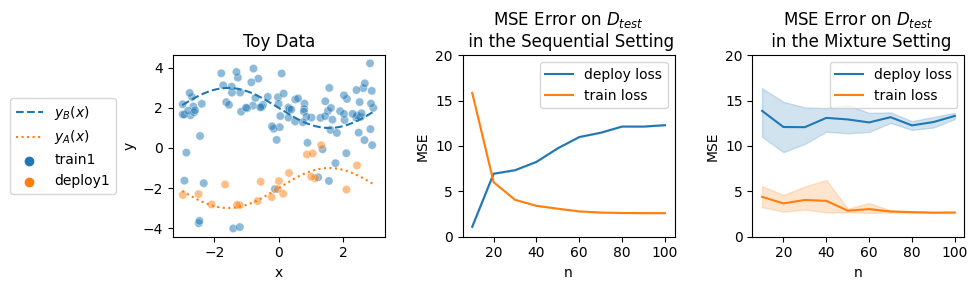

<IPython.core.display.Javascript object>

In [40]:
## plot data, sequential, and mixture setting


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
ax = axes.flatten()[0]

plot_df = data_df[data_df["series"].isin(["train1", "deploy1"])]
ax.plot(x, -np.sin(x) + offset, linestyle="--", label="$y_B(x)$")
ax.plot(x, np.sin(x) - offset, linestyle=":", label="$y_A(x)$")
sns.scatterplot(data=plot_df, x="x", y="y", hue="series", ax=ax, alpha=0.5)
ax.legend(loc='center left', bbox_to_anchor=(-0.8, 0.5))
ax.set_title("Toy Data")

ax = axes.flatten()[1]
df1, clf1 = nn_pipeline(
    data_df[data_df["series"] == "train1"]["x"].values,
    data_df[data_df["series"] == "train1"]["y"].values,
    data_df[data_df["series"] == "deploy1"]["x"].values,
    data_df[data_df["series"] == "deploy1"]["y"].values,
    hidden_layer_size=(8, 3),
    num_iter=5,
    random_sample=False,
)

sns.lineplot(data=df1, x="n", y="dep_mse", ax=ax, label="deploy loss")
sns.lineplot(data=df1, x="n", y="train_mse", ax=ax, label="train loss")
ax.set_ylim(0, 20)
ax.set_ylabel("MSE")
ax.set_title("MSE Error on $D_{test}$ \n in the Sequential Setting")


ax = axes.flatten()[2]
df1, clf1 = nn_pipeline(
    data_df[data_df["series"] == "train1"]["x"].values,
    data_df[data_df["series"] == "train1"]["y"].values,
    data_df[data_df["series"] == "deploy1"]["x"].values,
    data_df[data_df["series"] == "deploy1"]["y"].values,
    hidden_layer_size=(8, 3),
    num_iter=5,
    random_sample=True,
)

sns.lineplot(data=df1, x="n", y="dep_mse", ax=ax, label="deploy loss")
sns.lineplot(data=df1, x="n", y="train_mse", ax=ax, label="train loss")
ax.set_ylim(0, 20)
ax.set_ylabel("MSE")
ax.set_title("MSE Error on $D_{test}$ \n in the Mixture Setting")
fig.tight_layout()
plt.savefig("../results/toy_data.pdf")

<AxesSubplot: xlabel='n', ylabel='dep_mse'>

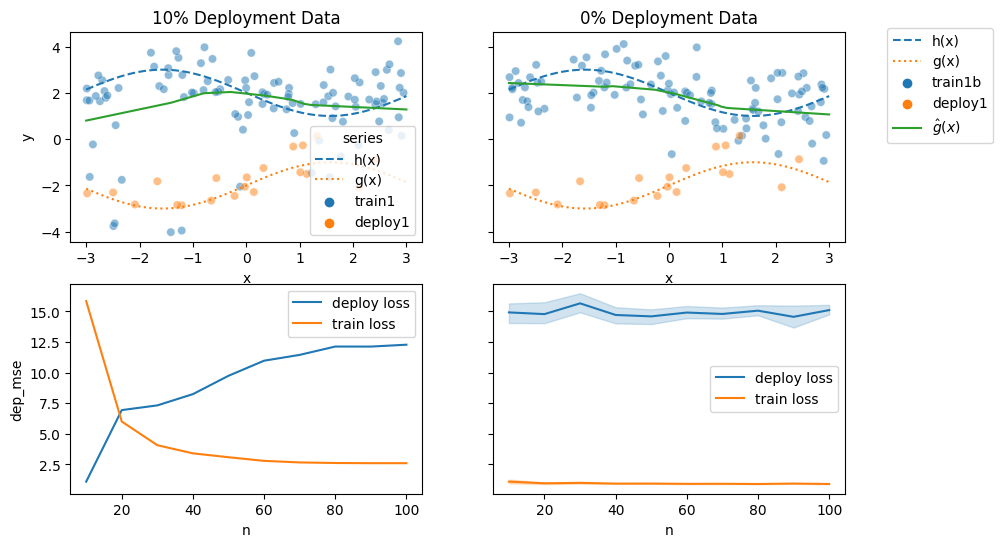

<IPython.core.display.Javascript object>

In [14]:
## Compare loss between no deployment data in training distribution and 10% deploy data

df0, clf0 = nn_pipeline(
    data_df[data_df["series"] == "train1b"]["x"].values,
    data_df[data_df["series"] == "train1b"]["y"].values,
    data_df[data_df["series"] == "deploy1"]["x"].values,
    data_df[data_df["series"] == "deploy1"]["y"].values,
    hidden_layer_size=(8, 3),
    num_iter=5,
)

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey="row")
plot_df = data_df[data_df["series"].isin(["train1", "deploy1"])]

ax = axes.flatten()[0]
ax.plot(x, -np.sin(x) + offset, linestyle="--", label="h(x)")
ax.plot(x, np.sin(x) - offset, linestyle=":", label="g(x)")
sns.scatterplot(data=plot_df, x="x", y="y", hue="series", ax=ax, alpha=0.5)
ax.plot(x, clf1.predict(x.reshape(-1, 1)), linestyle="-", label="$\hat{g(x)}$")
ax.set_title("10% Deployment Data")

plot_df = data_df[data_df["series"].isin(["train1b", "deploy1"])]
ax = axes.flatten()[1]
ax.plot(x, -np.sin(x) + offset, linestyle="--", label="h(x)")
ax.plot(x, np.sin(x) - offset, linestyle=":", label="g(x)")
sns.scatterplot(data=plot_df, x="x", y="y", hue="series", ax=ax, alpha=0.5)
ax.plot(x, clf0.predict(x.reshape(-1, 1)), linestyle="-", label=r"$\hat{g}(x)$")
ax.set_title("0% Deployment Data")
ax.legend(bbox_to_anchor=(1.1, 1.05))

sns.lineplot(data=df1, x="n", y="dep_mse", ax=axes.flatten()[2], label="deploy loss")
sns.lineplot(data=df0, x="n", y="dep_mse", ax=axes.flatten()[3], label="deploy loss")
sns.lineplot(data=df1, x="n", y="train_mse", ax=axes.flatten()[2], label="train loss")
sns.lineplot(data=df0, x="n", y="train_mse", ax=axes.flatten()[3], label="train loss")

In [17]:
# plot training curve and fitted curve through iterations

df1, clf1, approx, train_points, loss_curves = nn_pipeline(
    data_df[data_df["series"] == "train1"]["x"].values,
    data_df[data_df["series"] == "train1"]["y"].values,
    data_df[data_df["series"] == "deploy1"]["x"].values,
    data_df[data_df["series"] == "deploy1"]["y"].values,
    approx_range=x,
    num_iter=1,
    loss_curve=True,
    random_sample=False,
)

<IPython.core.display.Javascript object>

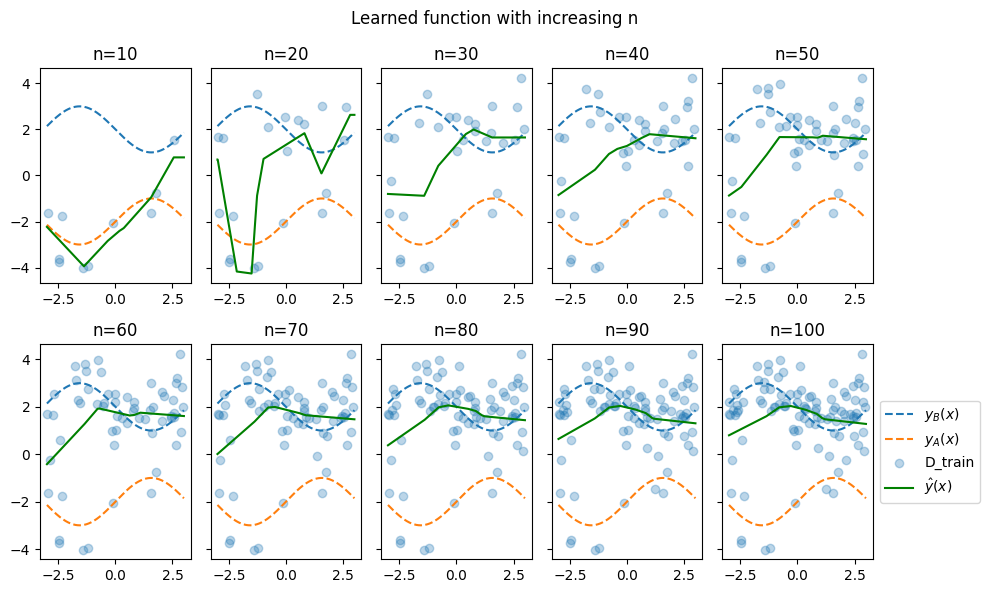

<IPython.core.display.Javascript object>

In [41]:
fig, axes = plt.subplots(2, 5, figsize=(10, 6), sharey="row")
for i, ax in enumerate(axes.flatten()):
    ax.plot(x, -np.sin(x) + offset, linestyle="--", label="$y_B(x)$")
    ax.plot(x, np.sin(x) - offset, linestyle="--", label="$y_A(x)$")
    ax.scatter(
        data_df[data_df["series"] == "train1"]["x"].values[train_points[i]],
        data_df[data_df["series"] == "train1"]["y"].values[train_points[i]],
        alpha=0.3,
        label="D_train",
    )
    ax.plot(x, approx[i], linestyle="-", label="$\hat{y}(x)$", color="g")
    ax.set_title(f"n={(i+1)*10}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Learned function with increasing n')
plt.tight_layout()
plt.savefig("../results/toy_data_learned.pdf")

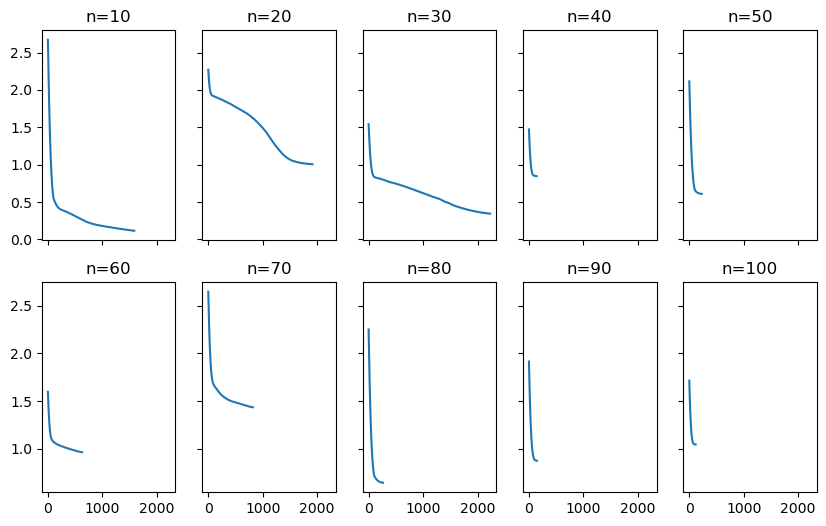

<IPython.core.display.Javascript object>

In [503]:
fig, axes = plt.subplots(2, 5, figsize=(10, 6), sharey="row", sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(len(loss_curves[i])), loss_curves[i], linestyle="-")
    ax.set_title(f"n={(i+1)*10}")

### Subgroup loss example

In [514]:
data_df["group"] = data_df["x"] >= 0

<IPython.core.display.Javascript object>

In [537]:
df1, clf1 = nn_pipeline(
    data_df[data_df["series"] == "train1"]["x"].values,
    data_df[data_df["series"] == "train1"]["y"].values,
    data_df[data_df["series"] == "deploy1"]["x"].values,
    data_df[data_df["series"] == "deploy1"]["y"].values,
    hidden_layer_size=(8, 3),
    num_iter=1,
    group_loss=True,
    # random_sample=False,
)

<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='n', ylabel='pos_mse'>

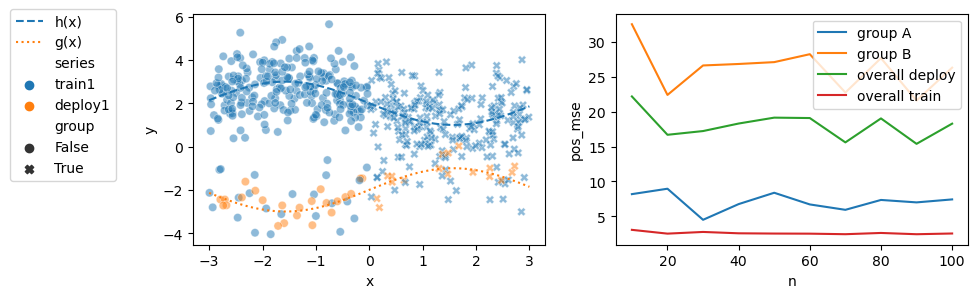

<IPython.core.display.Javascript object>

In [538]:
plot_df = data_df[data_df["series"].isin(["train1", "deploy1"])]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
ax = axes.flatten()[0]
ax.plot(x, -np.sin(x) + offset, linestyle="--", label="h(x)")
ax.plot(x, np.sin(x) - offset, linestyle=":", label="g(x)")
sns.scatterplot(
    data=plot_df, x="x", y="y", hue="series", style="group", ax=ax, alpha=0.5
)
ax.legend(bbox_to_anchor=(-0.2, 1.05))


ax = axes.flatten()[1]
sns.lineplot(data=df1, x="n", y="pos_mse", ax=ax, label="group A")
sns.lineplot(data=df1, x="n", y="neg_mse", ax=ax, label="group B")
sns.lineplot(data=df1, x="n", y="dep_mse", ax=ax, label="overall deploy")
sns.lineplot(data=df1, x="n", y="train_mse", ax=ax, label="overall train")